In [366]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings 
warnings.filterwarnings('ignore')

In [367]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


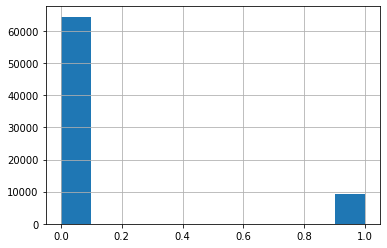

In [368]:
data.default.hist()

In [369]:
def display_normalized_values_for(series, dropna=False):
    print(data[series.name].value_counts(dropna=dropna, normalize=True).head(10))

#### Заполнение пропусков education

In [370]:
import random

# рассмотрим как распределены уровни образования в датасете
display_normalized_values_for(data.education, dropna=False)

# для заполнения пропусков сгенерируем случайное число от 0 до 1000
# если попадает в 0.2% верхних значений -  ACD
# если в 1.7% - PGR и т. д.
educations = {'ACD': range(998, 1001),
              'PGR': range(983, 998),
              'UGR': range(846, 983),
              'GRD': range(529, 846),
              'SCH': range(0, 529)}

def fill_education_nans(element):
    if pd.isna(element):
        randomized = random.randint(0, 1000)
        for education in educations:
            if randomized in educations[education]:
                return education
    else:
        return element


if len(data[data.education.isna()]) > 0:
    data.education = data.education.apply(fill_education_nans)

# убедимся в отсутсвии пропусков и рассмотрим новое распределение
display_normalized_values_for(data.education, dropna=False)

SCH    0.526565
GRD    0.316603
UGR    0.133010
PGR    0.017033
NaN    0.004160
ACD    0.002629
Name: education, dtype: float64
SCH    0.528706
GRD    0.317999
UGR    0.133579
PGR    0.017060
ACD    0.002656
Name: education, dtype: float64


#### Распределение признаков

In [371]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

#### Распределение

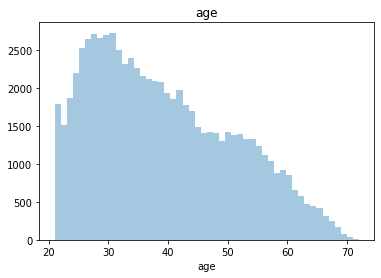

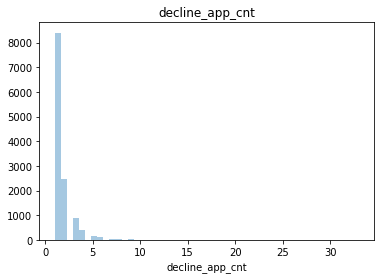

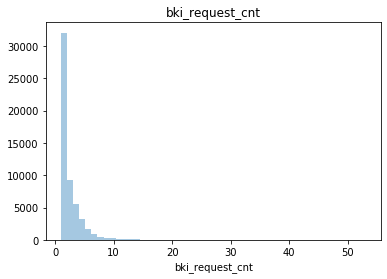

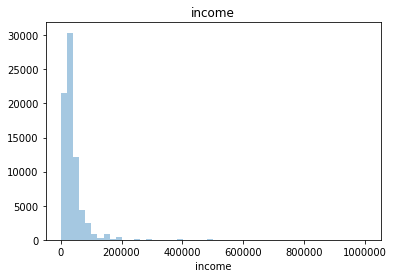

In [372]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

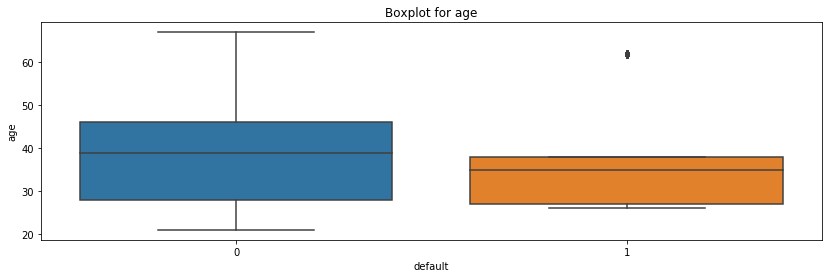

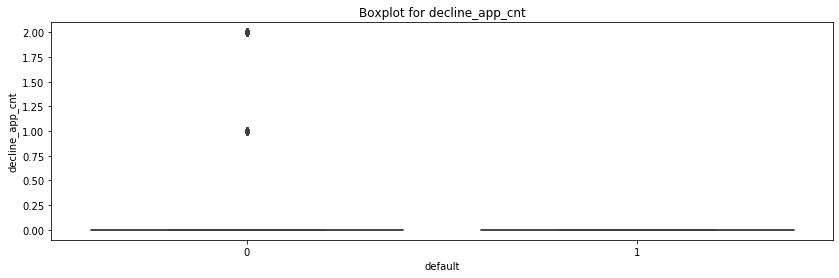

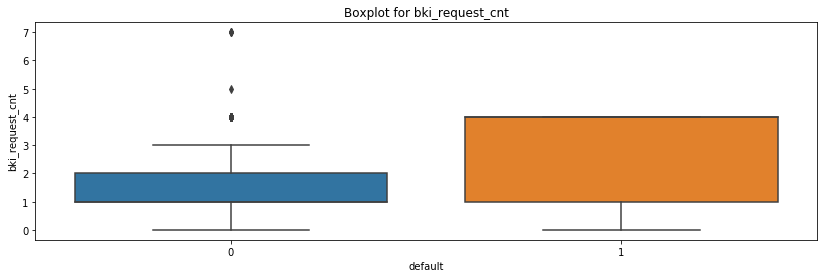

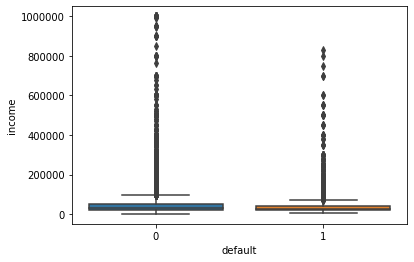

In [373]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='default', y=column,
                data=data.loc[data.loc[:, column]],
                ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in num_cols:
    if col == 'income':
        sns.boxplot(x ='default', y = col, data = data)
    else:
        get_boxplot(col)

#### Оценка корреляций

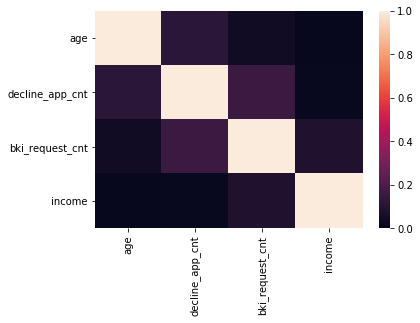

In [374]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

#### Непрерывность переменыых

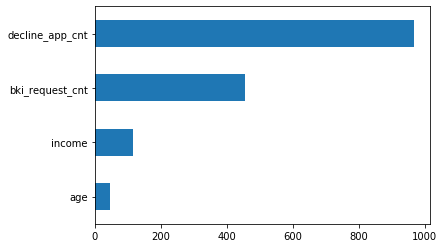

In [375]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### Обработка бинарных переменных

In [376]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
       
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


#### Обработка категориальных переменных

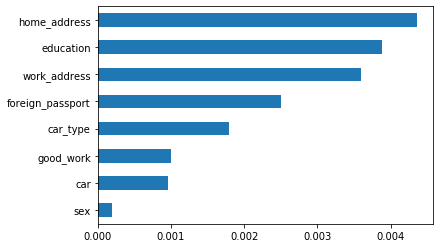

In [377]:
label_encoder.fit(data["education"])
data["education"] = label_encoder.transform(data["education"])

imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

#### OneHot Encoding

In [378]:
encoder = OneHotEncoder(sparse = False)
X_cat = encoder.fit_transform(data[cat_cols].values)

X_num = StandardScaler().fit_transform(data[num_cols].values)

X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

#### Обучение модели

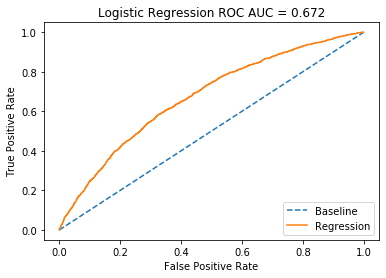

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### Гиперпараметры

In [380]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0
